**Step 1: Import necessary libraries**

In [23]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Set a random seed for reproducibility
np.random.seed(42)

**Step 2: Load and Inspect the Metadata**

In [24]:
# Load the metadata CSV file
metadata_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
skin_df = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
print(skin_df.head())

# Check for missing values
print(skin_df.isnull().sum())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


**Step 3: Preprocess the Data (Label Encoding)**

In [25]:
# Label encoding for 'dx' column (diagnosis)
le = LabelEncoder()
skin_df['label'] = le.fit_transform(skin_df['dx'])

# Display the classes for the 'dx' column
print(list(le.classes_))

# Inspect the new label column
print(skin_df[['dx', 'label']].head())

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    dx  label
0  bkl      2
1  bkl      2
2  bkl      2
3  bkl      2
4  bkl      2


**Step 4: Visualize the Dataset Distribution**

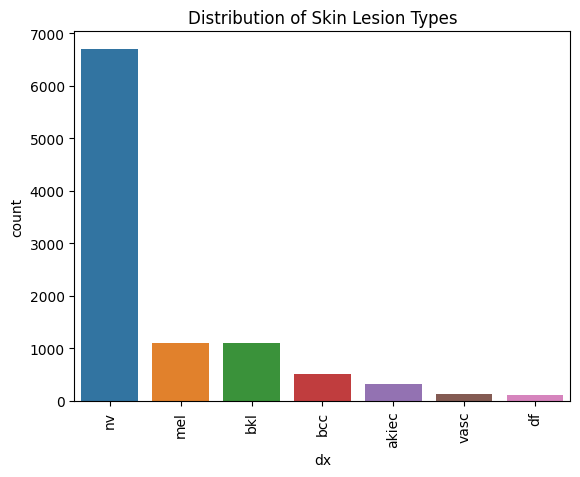

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


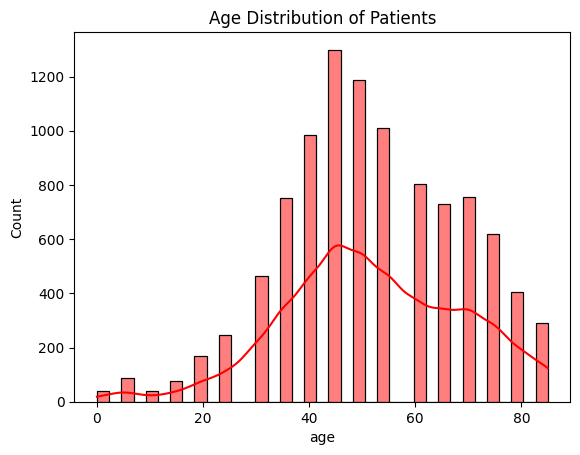

In [28]:
# Plotting the distribution of different skin lesion types (dx)
if 'dx' in skin_df.columns:
    # Ensure the 'dx' column is treated as a pandas Series and reorder based on value counts
    sns.countplot(x='dx', data=skin_df, order=skin_df['dx'].value_counts().index)
    plt.xticks(rotation=90)
    plt.title('Distribution of Skin Lesion Types')
    plt.show()
else:
    print("Column 'dx' not found in the DataFrame.")

# Plot the age distribution of patients
sns.histplot(skin_df['age'], kde=True, color='red')
plt.title('Age Distribution of Patients')
plt.show()


**Step 5: Load and Resize Images**

In [30]:
# Define the image size for resizing
IMAGE_SIZE = 32

# Load images from both parts of the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

def load_and_resize_image(image_id):
    try:
        # Check if the image is in part 1
        img_path = os.path.join(image_dir_1, f"{image_id}.jpg")
        if not os.path.exists(img_path):
            # Check if the image is in part 2
            img_path = os.path.join(image_dir_2, f"{image_id}.jpg")
        img = Image.open(img_path)
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_id}: {e}")
        return None

# Load and resize all images based on image_id in metadata
images = np.array([load_and_resize_image(image_id) for image_id in skin_df['image_id'] if load_and_resize_image(image_id) is not None])

# Convert labels to categorical
labels = to_categorical(skin_df['label'], num_classes=7)

**Step 6: Split the Data into Training and Testing Sets**

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")

Training set size: 8012 images
Test set size: 2003 images


**Step 7: Build and Train the CNN Model**

In [32]:
# Build the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 classes for 7 types of lesions

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5770 - loss: 5.7077 - val_accuracy: 0.6675 - val_loss: 1.0669
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6574 - loss: 1.0482 - val_accuracy: 0.6770 - val_loss: 1.0696
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6554 - loss: 0.9868 - val_accuracy: 0.6680 - val_loss: 1.0110
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6661 - loss: 0.9594 - val_accuracy: 0.6680 - val_loss: 1.0186
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6776 - loss: 0.9142 - val_accuracy: 0.6920 - val_loss: 0.9272
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6755 - loss: 0.8932 - val_accuracy: 0.6950 - val_loss: 0.9264
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6954 - loss: 0.8860 - val_accuracy: 0.6895 - val_loss: 0.8725
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6829 - loss: 0.8901 - val_ac

**Step 8: Evaluate the Model**

In [33]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6642 - loss: 0.8676
Test accuracy: 0.68


**Step 9: Confusion Matrix and Model Performance**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


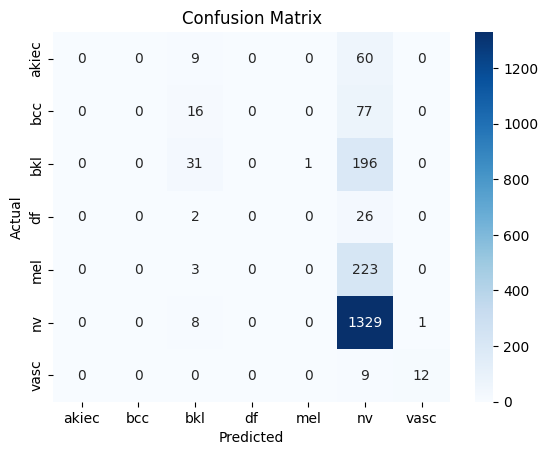

In [34]:
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Analyze Model Performance**

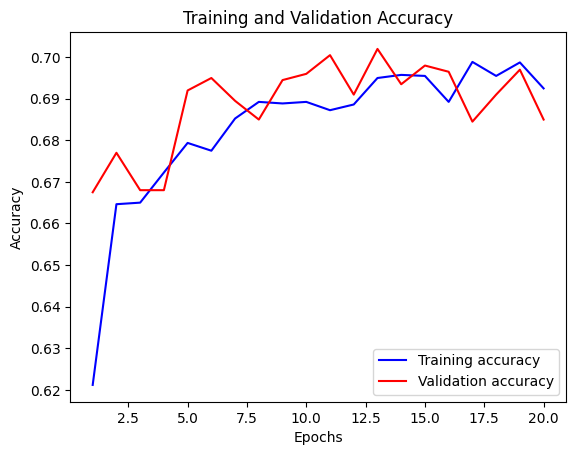

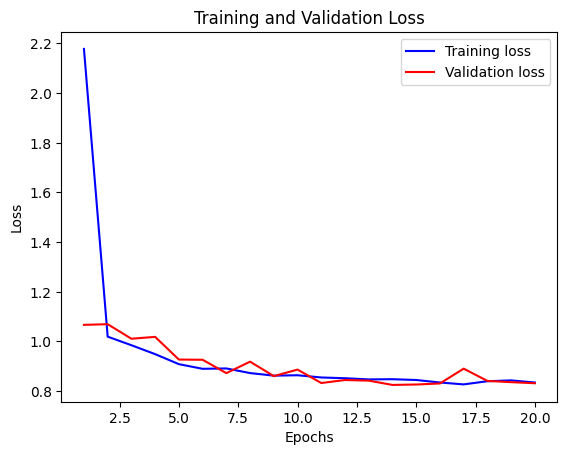

In [35]:
# Plot accuracy and loss curves
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Analyze Model History**

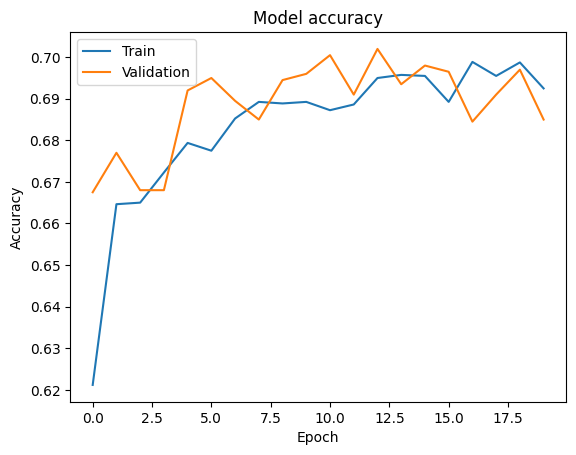

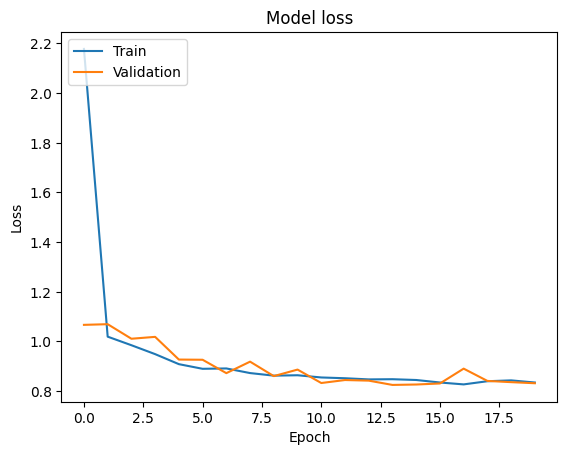

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Model saved**

In [37]:
model.save('skin_cancer_classifier.h5')

**Making Predictions and saving Results**

In [38]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

results_df = pd.DataFrame({
    'True Class': y_true,
    'Predicted Class': predicted_classes
})
results_df.to_csv('predictions.csv', index=False)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
